# Проект "Промышленность"

### Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы

1. Подготовить данные. Изменить типы данных; определить и использовать номера партий, у которых есть замеры по температуре.
2. Подготовка признаков. Составление единой таблицы со всеми данными для модели. Выделение целевого признака как последний замер в серии замеров. Разделение на features и target со смешиванием данных.
3. Выбор моделей. Обучение регрессионных моделей, например, CatBoostRegressor, LGBMRegressor и т.д.
4. Оценка эффективности моделей на тестовой выборке, сравнение с валидационной моделью, основанной на средних показателях температуры

Подгрузим необходимые модули для работы.

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import optuna
import pickle
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler 
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import GridSearchCV

## 1. Изучение данных

In [3]:
#Функция для изучения данных в датасете

def dataset_info(data):
    data.info()
    display(data.head(10))
    display(data.describe(include='all'))
    print('Количество дубликатов:', data.duplicated().sum())
    print('Количество уникальных партий:', data['key'].nunique())

In [4]:
try:
    data_arc = pd.read_csv('./data_arc.csv')
    data_bulk = pd.read_csv('./data_bulk.csv')
    data_bulk_time = pd.read_csv('./data_bulk_time.csv')
    data_gas = pd.read_csv('./data_gas.csv')
    data_temp = pd.read_csv('./data_temp.csv')
    data_wire = pd.read_csv('./data_wire.csv')
    data_wire_time = pd.read_csv('./data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### 1.1 Данные об электродах

In [5]:
dataset_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14875,14876,NaN,NaN
top,NaN,2019-06-10 22:02:03,2019-05-03 11:06:02,NaN,NaN
freq,NaN,2,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.670441,0.452592
std,934.571502,NaN,NaN,0.408159,5.878702
min,1.000000,NaN,NaN,0.030002,-715.504924
25%,806.000000,NaN,NaN,0.395297,0.290991
50%,1617.000000,NaN,NaN,0.555517,0.415962
75%,2429.000000,NaN,NaN,0.857034,0.637371


Количество дубликатов: 0
Количество уникальных партий: 3214


* Имеем 14 876 строк
* Количество уникальных партий: 3214
* Необходимо изменить тип данных у "Начало нагрева дугой" и "Конец нагрева дугой" на datetime
* Пропусков и дубликатов нет
* Есть аномальное значение Реактивной мощности: -715. Возможно ошибка измерения

In [6]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


<AxesSubplot:>

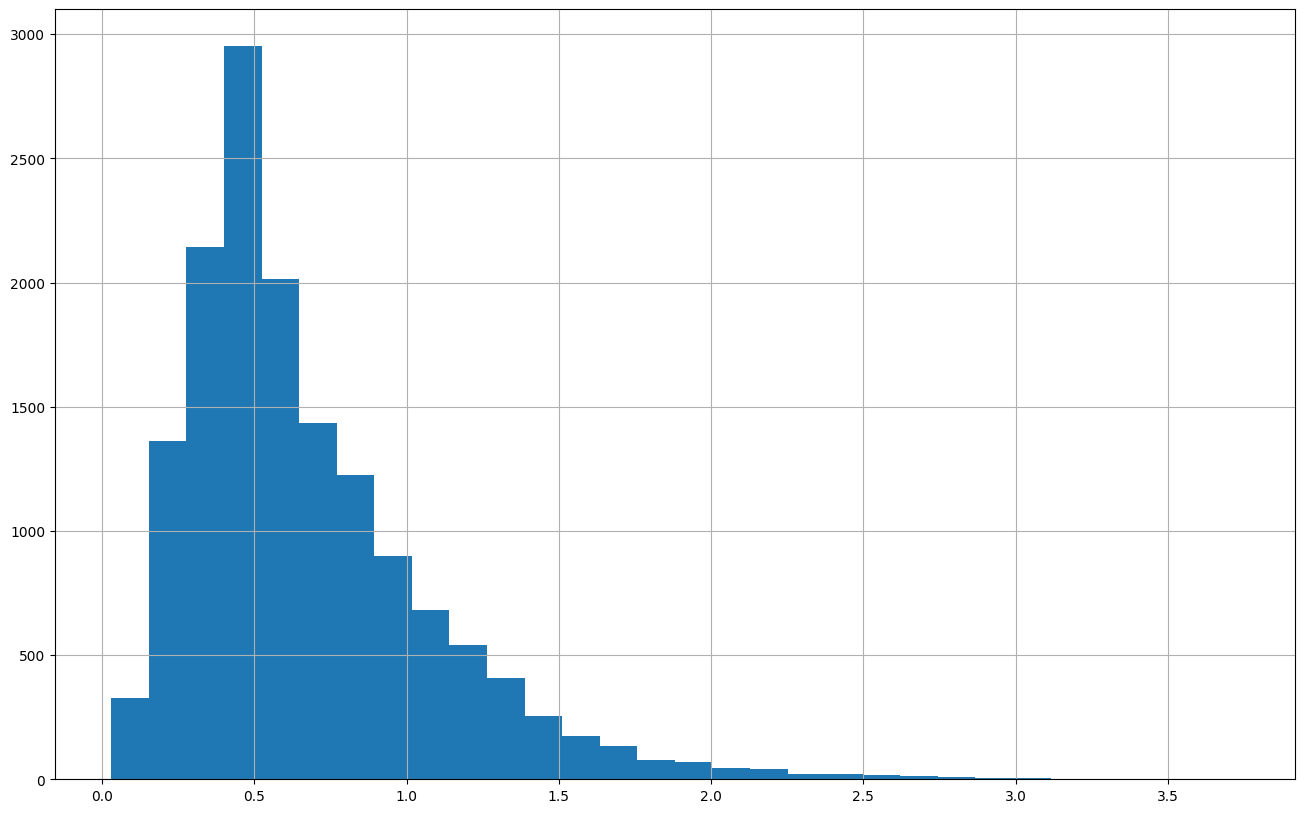

In [7]:
#Посмотрим на распределение активной мощности
data_arc['Активная мощность'].hist(bins=30, figsize=(16,10))

Нормальное рапредение со сдвигом влево

<AxesSubplot:>

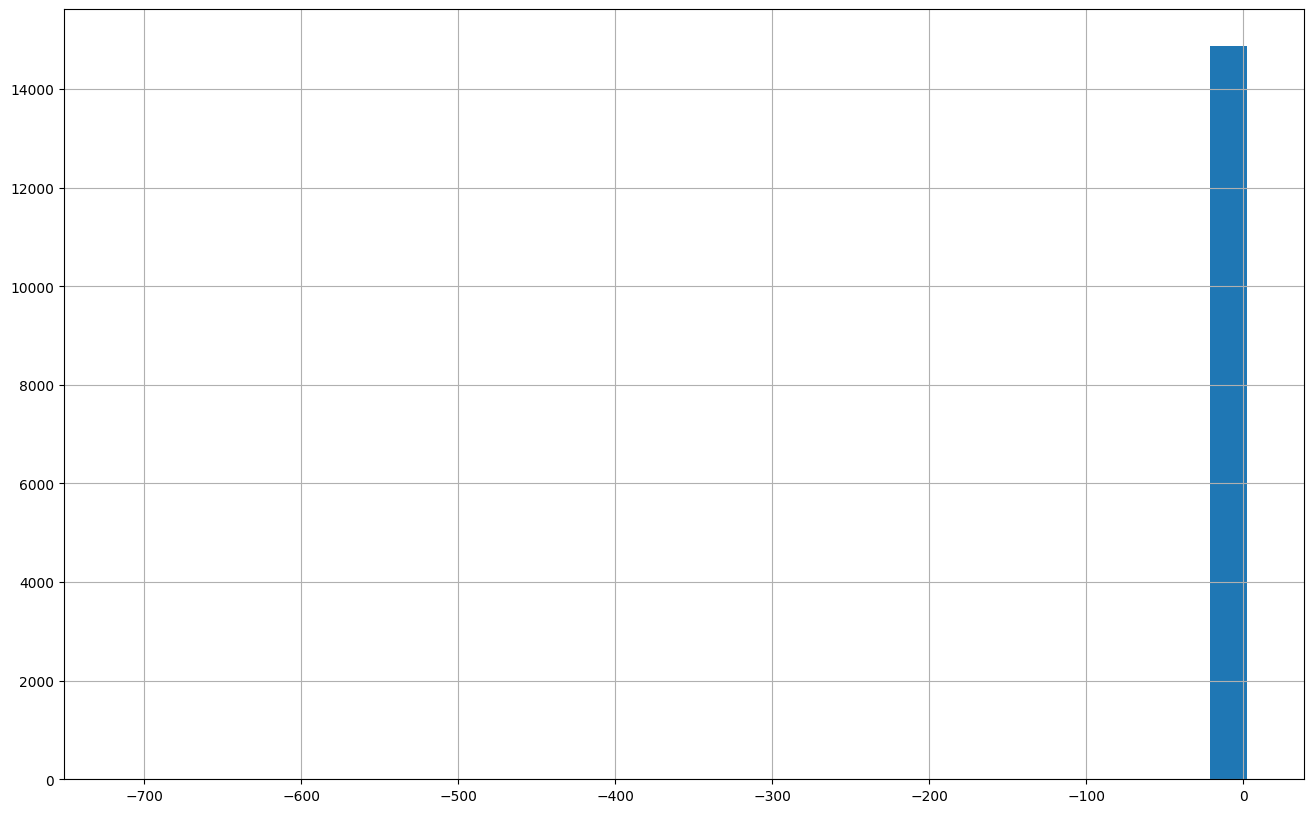

In [8]:
data_arc['Реактивная мощность'].hist(bins=30, figsize=(16,10))

In [9]:
#Избавимся от выбросов меньше нуля
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

<AxesSubplot:>

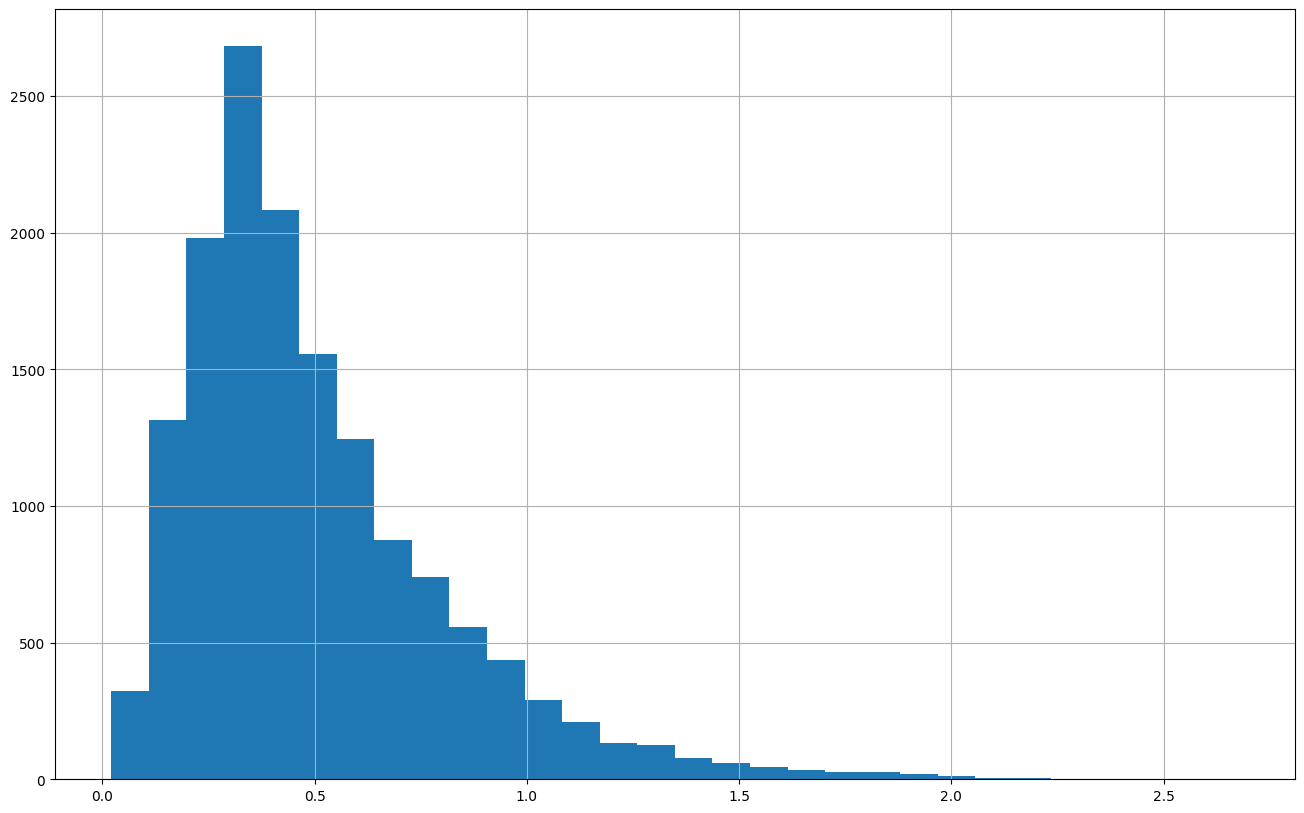

In [10]:
data_arc['Реактивная мощность'].hist(bins=30, figsize=(16,10))

Нормальное рапредение со сдвигом влево

### 1.2 Данные о подаче сыпучих материалов (объём)

In [11]:
dataset_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов: 0
Количество уникальных партий: 3129


* Дубликаты отсутствуют.
* Есть много пропущенных значений из-за того что для каждой партии добавляют опредленное сочетание сыпучих материалов.

### 1.3 Данные о подаче сыпучих материалов (время)

In [12]:
dataset_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество дубликатов: 0
Количество уникальных партий: 3129


- Много пропусков
- Дубликатов нет, Имеются типы данных, которые нужно исправить
- В построении будущей модели данный датасет не будет использован, поэтому нет необходимости проводить его предобработку

### 1.4 Данные о продувке сплава газом

In [13]:
dataset_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов: 0
Количество уникальных партий: 3239


<AxesSubplot:>

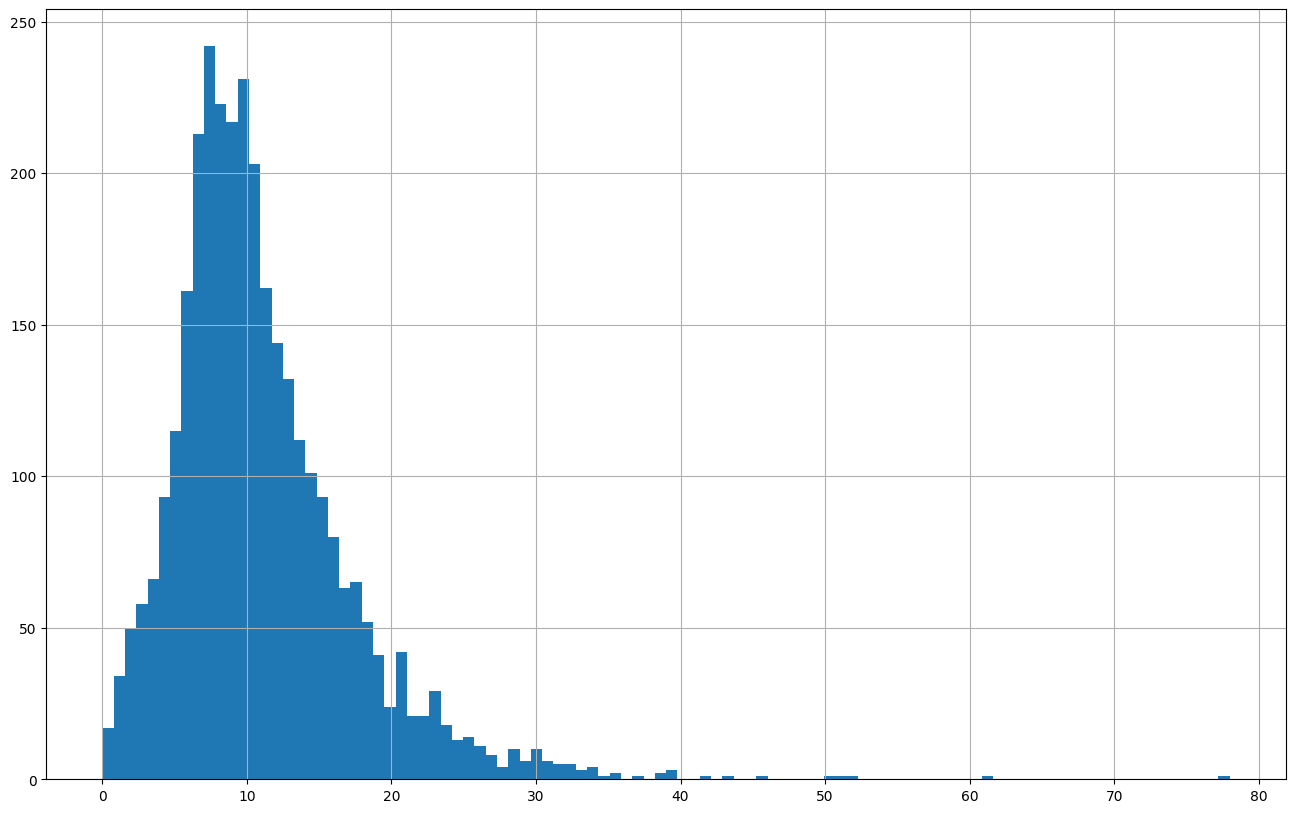

In [14]:
data_gas['Газ 1'].hist(bins=100, figsize=(16,10))

- Распределение нормальное
- Дубликатов и пропусков нет

### 1.5 Результаты измерения температуры

In [15]:
dataset_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Время замера,Температура
count,15907.000000,15907,13006.000000
unique,NaN,15907,NaN
top,NaN,2019-05-03 11:16:18,NaN
freq,NaN,1,NaN
mean,1607.880870,NaN,1591.840920
std,942.212073,NaN,21.375851
min,1.000000,NaN,1191.000000
25%,790.000000,NaN,1581.000000
50%,1618.000000,NaN,1591.000000
75%,2427.000000,NaN,1601.000000


Количество дубликатов: 0
Количество уникальных партий: 3216


In [16]:
#Изменим тип данных у время замера
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


<AxesSubplot:>

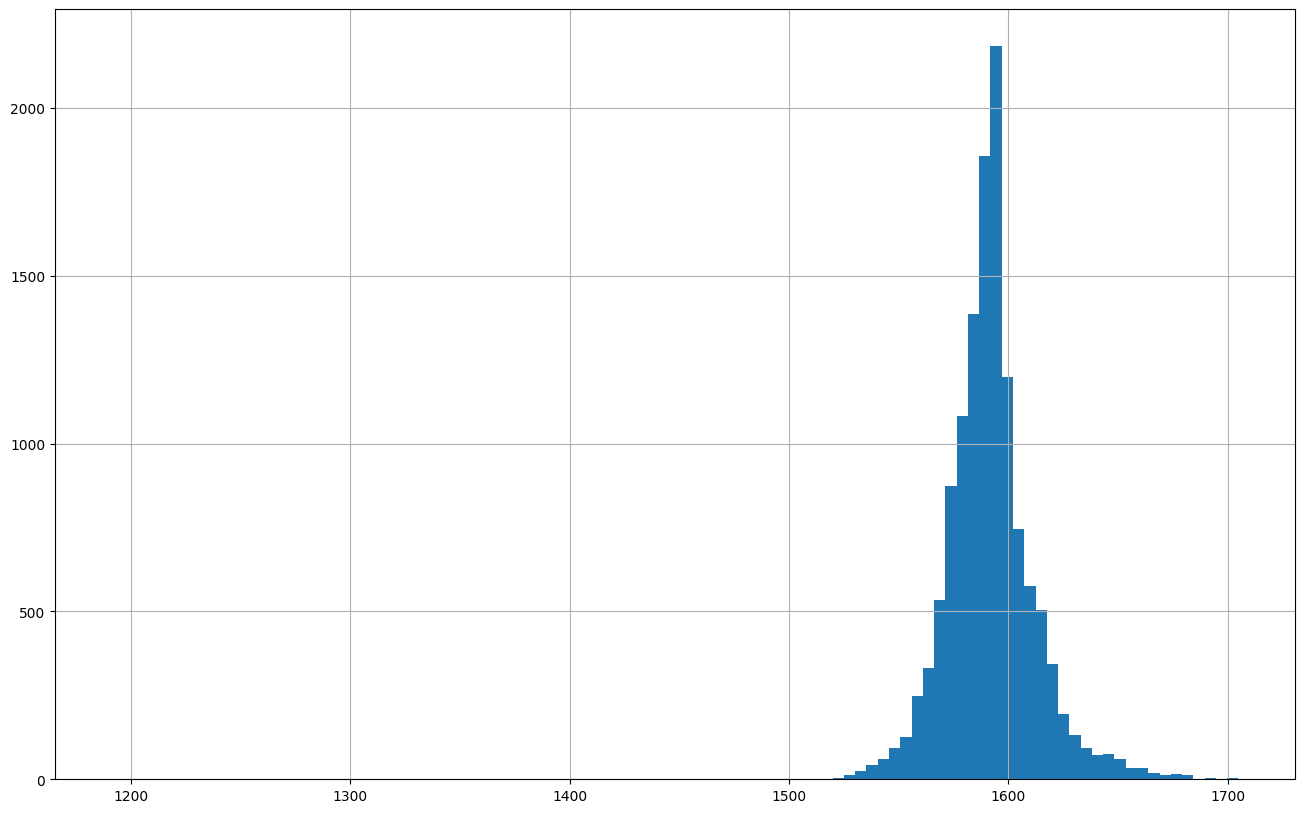

In [17]:
data_temp['Температура'].hist(bins=100, figsize=(16,10))

In [18]:
data_temp = data_temp.dropna()

- В датасете есть пропуски значений температуры. Это целевой признак, поэтому пропущенные значения удалила
- Распределение выглядит нормальным, но имеются аномальные выбросы
- Исправила тип данных у Время замера на datetime
- Дубликатов нет

### 1.6 Данные о проволочных материалах (объём)

In [19]:
dataset_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов: 0
Количество уникальных партий: 3081


- Дубликатов нет
- Есть пустые значения, скорее всего они пустые потому что различные виды проволочных материалов поступали в разных пропорциях в разные промежутки времени

### 1.7 Данные о проволочных материалах (время)

In [20]:
dataset_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:42:00,2019-05-14 00:03:32,2019-05-04 16:09:11
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество дубликатов: 0
Количество уникальных партий: 3081


In [ ]:
- Дубликатов нет
- Есть пропуски
- Типы данных не буду менять: данный датасет не буду использовать в простроении модели

### Выводы по пункту 1

- Загрузила и изучила данные
- Избавилась от некоторых аномальных значений.
- Изменилаи типы данных на Datetime
- Проверила данные на пропуски и дубликаты.

Данные требуют предобработки и группировки по признаку key. Данные активной и реактивной мощности распределены нормально со смещением влево, данные о температуре распределены нормально без смещения.

##  2. Предобработка данных

Найдем партии, в которых было как минимум 2 измерения температуры

In [21]:
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)
good_key = data_temp['key']
good_key

0           1
1           1
2           1
3           1
4           1
         ... 
13001    3237
13002    3238
13003    3239
13004    3240
13005    3241
Name: key, Length: 13006, dtype: int64

In [22]:
good_key = good_key[good_key.duplicated()].drop_duplicates()
good_key

1           1
6           2
12          3
17          4
20          5
         ... 
12251    2495
12254    2496
12258    2497
12260    2498
12265    2499
Name: key, Length: 2475, dtype: int64

Выберем партии, которые соотвествуют условию

In [23]:
data_temp = data_temp.query('key in @good_key')
data_arc = data_arc.query('key in @good_key')
data_bulk = data_bulk.query('key in @good_key')
data_wire = data_wire.query('key in @good_key')

In [24]:
#Сгруппируем данные по партии по первым и последним значениям температуры, последние значения необходимо будет предсказывать.
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = ['key', 'start_time', 'end_time', 'first_temp', 'last_temp']
data_temp = data_temp[['key', 'first_temp', 'last_temp']]
data_temp['first_temp'] = pd.to_numeric(data_temp['first_temp'], downcast='integer')
data_temp['last_temp'] = pd.to_numeric(data_temp['last_temp'], downcast='integer')
data_temp

,key,first_temp,last_temp
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602
...,...,...,...
2470,2495,1570,1591
2471,2496,1554,1591
2472,2497,1571,1589
2473,2498,1591,1594


In [29]:
# сгруппируем данные по партиям
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()
data_arc

,key,Активная мощность,Реактивная мощность
0,1,4.878147,3.183241
1,2,3.052598,1.998112
2,3,2.525882,1.599076
3,4,3.209250,2.060298
4,5,3.347173,2.252643
...,...,...,...
2470,2495,3.210690,2.360777
2471,2496,4.203064,2.810185
2472,2497,2.212379,1.851269
2473,2498,3.408725,2.355428


In [30]:
# заполним пропуски нулями
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)
data_gas = data_gas.fillna(0)

In [31]:
# объединим обработанные датасеты по ключу key
data = (data_temp.merge(data_arc, how = 'inner', on = 'key')
                 .merge(data_wire, how = 'inner', on = 'key')
                 .merge(data_bulk, how = 'inner', on = 'key')
                 .merge(data_gas, how = 'inner', on = 'key')
       )

# переименуем столбцы для корректной работы lgbm
data = data.rename(columns={'Активная мощность': 'active_power',
                            'Реактивная мощность': 'reactive_power',
                            'Полная мощность':'full_power',
                            'Работа': 'work',
                            'Газ 1': 'gas_1'})

# уберем колонку-индентификатор key, которую мы использовали
# для объединения датасетов
data = data.drop(['key'], axis = 1)

Определим корреляцию данных

In [32]:
data.corr()

,first_temp,last_temp,active_power,reactive_power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas_1
first_temp,1.000000,0.252443,-0.347621,-0.325661,0.209444,-0.086089,-0.000178,0.064991,NaN,0.019884,...,0.074729,-0.009320,-0.026216,0.035408,-0.087791,-0.058495,0.018606,-0.131024,-0.040349,0.037341
last_temp,0.252443,1.000000,0.290434,0.240980,0.317575,-0.206672,-0.047537,-0.159719,NaN,-0.084034,...,-0.107275,-0.026587,-0.016075,0.061350,-0.114753,0.267424,-0.010920,0.114617,0.266414,0.059160
active_power,-0.347621,0.290434,1.000000,0.958486,0.051016,0.054665,0.035638,0.047639,NaN,0.053341,...,0.074424,-0.011401,0.023735,0.004783,0.071186,0.478083,0.122453,0.465205,0.334372,0.373767
reactive_power,-0.325661,0.240980,0.958486,1.000000,0.016931,0.052309,0.030751,0.075687,NaN,0.055222,...,0.100975,-0.008350,0.011113,-0.002496,0.075986,0.457266,0.116738,0.430002,0.297246,0.356824
Wire 1,0.209444,0.317575,0.051016,0.016931,1.000000,-0.068301,0.038075,-0.142005,NaN,-0.128036,...,-0.143267,0.034650,0.022596,0.062713,-0.117755,0.170167,0.039439,-0.053835,0.118437,0.117313
Wire 2,-0.086089,-0.206672,0.054665,0.052309,-0.068301,1.000000,0.094073,-0.033758,NaN,-0.058700,...,-0.000631,0.018912,0.066733,-0.103758,0.062067,-0.098263,-0.001390,0.036309,-0.096415,0.104248
Wire 3,-0.000178,-0.047537,0.035638,0.030751,0.038075,0.094073,1.000000,0.169810,NaN,0.183456,...,0.156626,-0.002400,-0.008282,-0.027977,-0.021829,-0.120469,-0.008685,-0.008859,-0.118076,0.103382
Wire 4,0.064991,-0.159719,0.047639,0.075687,-0.142005,-0.033758,0.169810,1.000000,NaN,0.445960,...,0.740572,-0.001336,-0.004609,-0.015571,-0.012153,-0.085535,-0.004833,-0.121828,-0.091352,0.145413
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.019884,-0.084034,0.053341,0.055222,-0.128036,-0.058700,0.183456,0.445960,NaN,1.000000,...,0.456101,-0.002334,-0.008055,-0.017800,0.008701,-0.042731,-0.008447,-0.052387,-0.032421,0.108089


In [33]:
#корреляция по целевому признаку
data.corr()['last_temp'] 

first_temp        0.252443
last_temp         1.000000
active_power      0.290434
reactive_power    0.240980
Wire 1            0.317575
Wire 2           -0.206672
Wire 3           -0.047537
Wire 4           -0.159719
Wire 5                 NaN
Wire 6           -0.084034
Wire 7           -0.137262
Wire 8           -0.010767
Wire 9           -0.027488
Bulk 1           -0.075206
Bulk 2           -0.082454
Bulk 3           -0.035977
Bulk 4            0.187970
Bulk 5           -0.028355
Bulk 6           -0.181816
Bulk 7           -0.107275
Bulk 8           -0.026587
Bulk 9           -0.016075
Bulk 10           0.061350
Bulk 11          -0.114753
Bulk 12           0.267424
Bulk 13          -0.010920
Bulk 14           0.114617
Bulk 15           0.266414
gas_1             0.059160
Name: last_temp, dtype: float64

Выберем данные, у которых корреляция с целевым признаком больше 0.2

In [34]:
data.corr()['last_temp'].abs() >= 0.2

first_temp         True
last_temp          True
active_power       True
reactive_power     True
Wire 1             True
Wire 2             True
Wire 3            False
Wire 4            False
Wire 5            False
Wire 6            False
Wire 7            False
Wire 8            False
Wire 9            False
Bulk 1            False
Bulk 2            False
Bulk 3            False
Bulk 4            False
Bulk 5            False
Bulk 6            False
Bulk 7            False
Bulk 8            False
Bulk 9            False
Bulk 10           False
Bulk 11           False
Bulk 12            True
Bulk 13           False
Bulk 14           False
Bulk 15            True
gas_1             False
Name: last_temp, dtype: bool

In [35]:
data = data[['first_temp', 'last_temp', 'active_power', 'Wire 1', 'Wire 2', 'Bulk 12', 'Bulk 15']]

Данные reactive_power не вошли, т.к. присутсвует корреляция с active_power. А активная мощность сильнее коррелирует с целевым признаком

In [36]:
data.corr()

,first_temp,last_temp,active_power,Wire 1,Wire 2,Bulk 12,Bulk 15
first_temp,1.000000,0.252443,-0.347621,0.209444,-0.086089,-0.058495,-0.040349
last_temp,0.252443,1.000000,0.290434,0.317575,-0.206672,0.267424,0.266414
active_power,-0.347621,0.290434,1.000000,0.051016,0.054665,0.478083,0.334372
Wire 1,0.209444,0.317575,0.051016,1.000000,-0.068301,0.170167,0.118437
Wire 2,-0.086089,-0.206672,0.054665,-0.068301,1.000000,-0.098263,-0.096415
Bulk 12,-0.058495,0.267424,0.478083,0.170167,-0.098263,1.000000,0.614479
Bulk 15,-0.040349,0.266414,0.334372,0.118437,-0.096415,0.614479,1.000000


## 3. ОБУЧЕНИЕ МОДЕЛЕЙ

In [37]:
random_state = 160123

features = data.drop('last_temp', axis=1)
target = data['last_temp']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=random_state)

cv_counts = 5
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(1746, 6) (583, 6)
(1746,) (583,)


In [38]:
#Масштабируем количественные признаки
scaler = StandardScaler()
scaler.fit(features_train)

# масштабируем обучающую выборку
features_train_scaler= scaler.transform(features_train)

# масштабируем тестовую выборку
features_test_scaler = scaler.transform(features_test)

### CatBoostRegressor

In [39]:
regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 6.383296571295162


In [40]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 160123,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04471199959516525,
 'score_functio

### LightGBM

In [41]:
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,31)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[random_state]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

Best parameters:

{'learning_rate': 0.05, 'num_leaves': 11, 'random_state': 160123}

Scores:

6.960876 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 160123}
6.940898 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 160123}
6.923528 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 160123}
6.907227 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 160123}
6.889841 for {'learning_rate': 0.01, 'num_leaves': 14, 'random_state': 160123}
6.872182 for {'learning_rate': 0.01, 'num_leaves': 15, 'random_state': 160123}
6.859334 for {'learning_rate': 0.01, 'num_leaves': 16, 'random_state': 160123}
6.847332 for {'learning_rate': 0.01, 'num_leaves': 17, 'random_state': 160123}
6.835749 for {'learning_rate': 0.01, 'num_leaves': 18, 'random_state': 160123}
6.819416 for {'learning_rate': 0.01, 'num_leaves': 19, 'random_state': 160123}
6.810034 for {'learning_rate': 0.01, 'num_leaves': 20, 'random_state': 160123}
6.792251 for {'learning_rate': 0.01, 

### Линейная регрессия

In [42]:
regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train_scaler, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

MAE LinearRegression = 6.690360562280254


In [46]:
index = ['LinearRegression',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['MAE < 6.8'] = scores_data['MAE на CV'] < 6.8
scores_data

,MAE на CV,MAE < 6.8
LinearRegression,6.690361,True
CatBoostRegressor,6.383297,True
LGBMRegressor,6.332188,True


#### Вывод:

Были обучены 3 модели: LinearRegression, CatBoostRegressor и LGBMRegressor. Наилучший результат: 6.33 на кроссвалидации показала модель LGBMRegressor, используем эту модель на тестовой выборке. Также с задачей MAE < 6.8 справились модели CatBoostRegressor и LinearRegression с результатом 6.38 и 6.69 соответсвенно. 

#  3.Тестирование модели

In [47]:
model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
print('MAE on test of LGBMRegressor =', test_MAE_LGBMR)

MAE on test of LGBMRegressor = 6.21285024397494


In [45]:
# Проверка модели на адекватность
# Создадим константную модель с помошью DummyRegressor
model = DummyRegressor(strategy='mean')


model.fit(features_train, target_train)
predictions = model.predict(features_test)

MAE_DR = mean_absolute_error(target_test, predictions)

print('MAE константной модели', MAE_DR)

MAE константной модели 7.988414587422567


#### Вывод
На тестовой модели LGBMRegressor показал МАЕ 6.21, что меньше целевого показателя 6.8. В качестве проверки на адекватность была выбрала модель DummyRegressor. MAE константной модели 7.99, следовательно модель LGBMRegressor адекватна.

## Итоговый вывод

В ходе работы над проектом было выполнено:

* Подготовлены данные. Изменены типы данных; определены и использованы номера партий, у которых есть замеры по температуре.
* Подготовлены признаки. Составлена единая таблица со всеми данными для модели. Выделен целевой признак как последний замер температуры. Разделены на features и target
* Выбраны модели. Использованы и обучены регрессионные модели LinearRegression, CatBoostRegressor, LGBMRegressor.
* Оценена эффективность моделей на тестовой выборке.
* Была произведена проверка на адекватностью моделью DummyRegressor

Лучшей моделью по метрике MAE = 6.21 стал LGBMRegressor, пройдена проверка на адекватность. Этот результат показывает, что в прогнозе температуры модель в среднем ошибается на 6 градусов. 

## Отчет

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Задачей проекта было построение модели, которая предскажет температуру стали с погрешностью не более 6.8 градусов.

Все пункты плана были выполнены.

В процессе обучения модели не удалось сразу достичь необходимого результата, ввиду недостаточной предобработки данных. После выделения партий, которые есть во всех датафреймах, данная проблема была решена. 

В нашем распоряжении было 7 датасетов с информацией об электродах, подаче сыпучих материалов (объем и время), данные о проволочных материалах (объем и время), данные о продувке сплава газом и результаты измерения температуры.

Определили корреляцию данных и выбрали признаки, у которых корреляция с целевым составила более 0.2: 'first_temp', 'active_power', 'Wire 1', 'Wire 2', 'Bulk 12', 'Bulk 15'. Данные были изучены, выявленные пропуски были заполнены нулями. Данные, содержащие информацию о дате и времени, были приведены к соответствующему типу. В качестве целевого признака было выбрано последнее измерение температуры стали. Следовательно, были исключены партии, в которых было только одно измерение температуры. Данные были сгруппированы по признаку key(партия).

По результатам обучения, наилучший результат: 6.33 на кроссвалидации и 6.21 на тестовой выборке, показала модель LGBMRegressor. Гиперпараметры модели: 
* learning_rate: 0.05, 
* num_leaves: 11, 
* random_state: 160123

В качестве проверки на адекватность была выбрала модель DummyRegressor. MAE константной модели 7.99, следовательно модель LGBMRegressor адекватна.